In [ ]:
import os
import cv2
import numpy as np
from scipy.ndimage import gaussian_filter
import random

def generate_gaussian_blob(image_size, center, sigma):
    """
    Create a single-channel Gaussian blob on an empty canvas.

    :param image_size: Tuple[int, int] (height, width) of the output image.
    :param center: Tuple[int, int] (x, y) pixel coordinates of the blob center.
    :param sigma: Float, standard deviation of the Gaussian.
    :return: np.ndarray of shape (height, width), values normalized to [0,1].
    """
    h, w = image_size
    canvas = np.zeros((h, w), dtype=np.float32)
    x, y = center

    if 0 <= x < w and 0 <= y < h:
        canvas[y, x] = 1.0

    canvas = gaussian_filter(canvas, sigma=sigma)
    if canvas.max() > 0:
        canvas /= canvas.max()
    return canvas

def generate_heatmap_and_boxes(image_size, num_blobs, sigma, offset_range):
    """
    Generate a heatmap with up to num_blobs Gaussian blobs clustered together,
    and compute each blob’s bounding box.

    :param image_size: Tuple[int, int] (height, width) of the image.
    :param num_blobs: Int, how many Gaussians to place (1 to 3).
    :param sigma: Float, Gaussian blur sigma for each blob.
    :param offset_range: Tuple[int, int], min and max pixel offset from the cluster center.
    :return:
        heatmap: np.ndarray of shape (h, w) with values in [0,1],
        boxes: List[Tuple[int, int, int, int]] as (x_min, y_min, x_max, y_max).
    """
    h, w = image_size
    margin = int(max(offset_range)*1.5 + sigma*3)
    cx = random.randint(margin, w - margin - 1)
    cy = random.randint(margin, h - margin - 1)

    centers = [(cx, cy)]
    for _ in range(1, num_blobs):
        angle = random.uniform(0, 2 * np.pi)
        dist = random.randint(offset_range[0], offset_range[1])
        dx = int(dist * np.cos(angle))
        dy = int(dist * np.sin(angle))
        centers.append((cx + dx, cy + dy))

    heatmap = np.zeros((h, w), dtype=np.float32)
    boxes = []

    for x, y in centers:
        blob = generate_gaussian_blob(image_size, (x, y), sigma)
        heatmap = np.maximum(heatmap, blob)

        box_size = int(sigma * 6)  # roughly ±3σ
        x_min = max(0, x - box_size // 2)
        y_min = max(0, y - box_size // 2)
        x_max = min(w - 1, x + box_size // 2)
        y_max = min(h - 1, y + box_size // 2)
        boxes.append((x_min, y_min, x_max, y_max))

    return heatmap, boxes

def generate_dataset(num_images, image_size, sigma, offset_range, output_dir):
    """
    Create a dataset of synthetic **colored** heatmap images and box annotations.

    :param num_images: Int, total images to generate.
    :param image_size: Tuple[int, int], (height, width) of each image.
    :param sigma: Float, Gaussian blur sigma for blobs.
    :param offset_range: Tuple[int, int], min/max blob‐cluster offset.
    :param output_dir: Path where `images/` and `labels/` folders will be created.
    :return: None
    """
    img_dir = os.path.join(output_dir, 'images')
    lbl_dir = os.path.join(output_dir, 'labels')
    os.makedirs(img_dir, exist_ok=True)
    os.makedirs(lbl_dir, exist_ok=True)

    for idx in range(num_images):
        n_blobs = random.randint(1, 5)
        heatmap, boxes = generate_heatmap_and_boxes(
            image_size, n_blobs, sigma, offset_range
        )

        # 1) Convert to 8-bit grayscale
        gray = (heatmap * 255).astype(np.uint8)

        # 2) Apply JET colormap → BGR color image
        colored = cv2.applyColorMap(gray, cv2.COLORMAP_JET)

        # 3) Save the colored heatmap
        img_path = os.path.join(img_dir, f'img_{idx:05d}.jpg')
        cv2.imwrite(img_path, colored)

        # 4) Save box coordinates
        lbl_path = os.path.join(lbl_dir, f'img_{idx:05d}.txt')
        with open(lbl_path, 'w') as f:
            for x_min, y_min, x_max, y_max in boxes:
                f.write(f"{x_min} {y_min} {x_max} {y_max}\n")





In [10]:
import os
import random
import cv2
import matplotlib.pyplot as plt

def show_image_with_boxes(image_path, label_path):
    """
    Load an image and its corresponding .txt labels, then display
    the image with bounding boxes overlaid.

    :param image_path: Path to the colored image (BGR on disk).
    :param label_path: Path to the .txt file with lines "x_min y_min x_max y_max".
    """
    # 1. Load & convert to RGB
    img_bgr = cv2.imread(image_path)
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    # 2. Read boxes
    boxes = []
    with open(label_path, 'r') as f:
        for line in f:
            x_min, y_min, x_max, y_max = map(int, line.strip().split())
            boxes.append((x_min, y_min, x_max, y_max))

    # 3. Plot
    fig, ax = plt.subplots(1, figsize=(6, 6))
    ax.imshow(img_rgb)
    for x_min, y_min, x_max, y_max in boxes:
        rect = plt.Rectangle(
            (x_min, y_min),
            x_max - x_min,
            y_max - y_min,
            linewidth=2,
            edgecolor='red',
            facecolor='none'
        )
        ax.add_patch(rect)

    ax.axis('off')
    plt.tight_layout()
    plt.show()


def visualize_random_samples(img_dir, lbl_dir, num_samples=5):
    """
    Pick a few random images from img_dir and display them with boxes.

    :param img_dir: Directory containing .jpg images.
    :param lbl_dir: Directory containing .txt labels.
    :param num_samples: How many random samples to display.
    """
    img_files = [f for f in os.listdir(img_dir) if f.lower().endswith('.jpg')]
    samples = random.sample(img_files, min(num_samples, len(img_files)))

    for img_name in samples:
        img_path = os.path.join(img_dir, img_name)
        lbl_path = os.path.join(lbl_dir, img_name.replace('.jpg', '.txt'))
        show_image_with_boxes(img_path, lbl_path)



In [22]:
IMAGE_DIR   = 'images'
LABEL_DIR   = 'labels'
HEATMAP_DIR = 'heatmaps_rgb'
IMAGE_SIZE   = (640, 640)
SIGMA        = 50
OFFSET_RANGE = (5, 50)
NUM_IMAGES   = 50
OUTPUT_DIR   = 'data/hm_dataset'


In [23]:
generate_dataset(
    num_images=NUM_IMAGES,
    image_size=IMAGE_SIZE,
    sigma=SIGMA,
    offset_range=OFFSET_RANGE,
    output_dir=OUTPUT_DIR
)


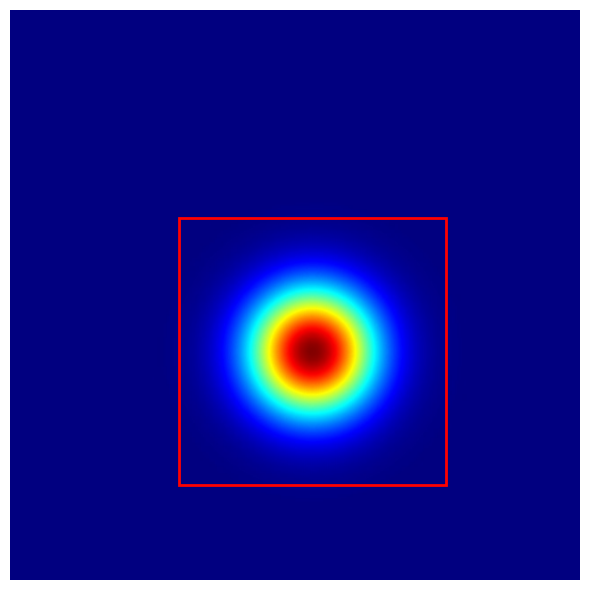

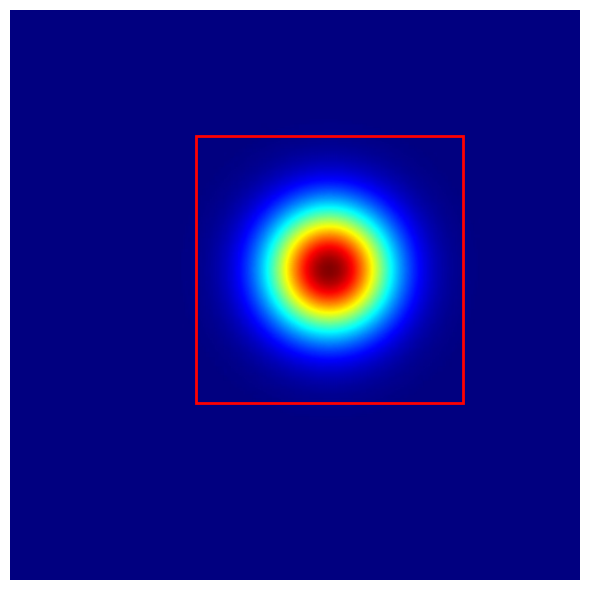

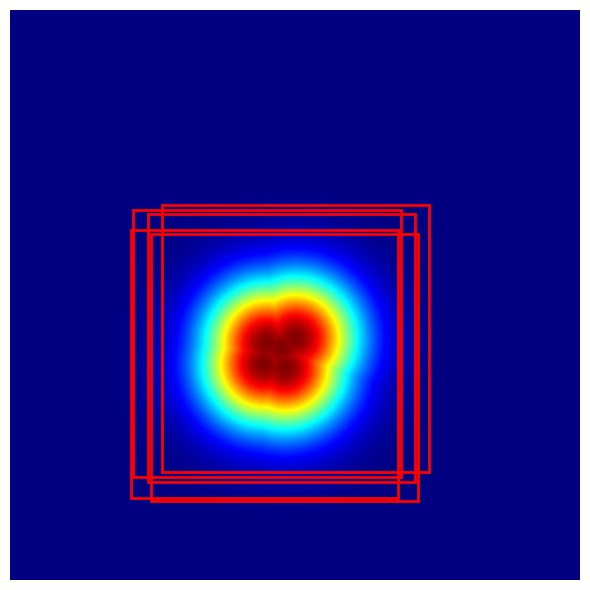

In [32]:
# Example usage:
visualize_random_samples(os.path.join(OUTPUT_DIR,IMAGE_DIR), os.path.join(OUTPUT_DIR,LABEL_DIR), num_samples=3)
